# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

__Содержание__  
* [Откроем файл](#Шаг-1.-Откройте-файлы-с-данными)  
* [Пред обработка](#Шаг-2.-Предобработка-и-исследовательский-анализ-данных)  
* [Формулировка ML-задачи](#Шаг-3.-Формулировка-ML-задачи-на-основе-бизнес-задачи)  
* [Разработка модели ML](#Шаг-4.-Разработка-модели-ML)  
* [Портрет «ненадёжного» клиента](#Шаг-5.-Опишите-портрет-«ненадёжного»-клиента)  
* [Общий вывод](#Шаг-6.-Напишите-общий-вывод)  

__Задача.__  
Разработать модель которыя будет предсказывать отмену забронированных номеров и за счет внесенных депозитов позволит компенсировать расходы на подготовку номера, также за год позволит заработать на депозитах 400 000₽.

### Шаг 1. Откройте файлы с данными

Стоимость номеров отеля:
* категория A: за ночь — 1 000, разовое обслуживание — 400;
* категория B: за ночь — 800, разовое обслуживание — 350;
* категория C: за ночь — 600, разовое обслуживание — 350;
* категория D: за ночь — 550, разовое обслуживание — 150;
* категория E: за ночь — 500, разовое обслуживание — 150;
* категория F: за ночь — 450, разовое обслуживание — 150;
* категория G: за ночь — 350, разовое обслуживание — 150;
* категория H: за ночь — 300, разовое обслуживание — 100.

In [1]:
import pandas as pd
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

In [2]:
pd.set_option('display.max_columns', 900)

In [3]:
scaler = StandardScaler()
encoder = OrdinalEncoder()

df_train = pd.read_csv('/datasets/hotel_train.csv')
df_test = pd.read_csv('/datasets/hotel_test.csv')

In [4]:
df1 = pd.DataFrame([['a', 1], ['b', 5]], columns=['letter', 'number'])
df2 = pd.DataFrame([['c', 4], ['d', 2]], columns=['letter', 'number'])
pd.concat([df1, df2], keys=['x', 'y'])
#dfc
#dfc2 = dfc.sort_values('number')
#dfc2.loc['x']

letter  number
x 0      a       1
  1      b       5
y 0      c       4
  1      d       2

### Шаг 2. Предобработка и исследовательский анализ данных

In [5]:
rc_train = df_train.shape
rc_test = df_test.shape
print('--Размеры датасетов--\n')
print(f'Тренировочный датасет: строки {rc_train[0]}, столбцы {rc_train[1]}')
print(f'Тестовый датасет: строки {rc_test[0]}, столбцы {rc_test[1]}')

print('\n--Типы столбцов--')
print(f'\nТренировочный датасет:\n{df_train.dtypes}')
print(f'\nТестовый датасет:\n{df_test.dtypes}')

print('\n--Посотмрим на пустые строки--')
print('\nТренировочный датасет')
print(df_train.isnull().sum())
print('\nТестовый датасет')
print(df_test.isnull().sum())

print('\nПосотмрим на дубли\n')
print(f'Тренировочный датасет: {df_train.duplicated().sum()}')
print(f'Тестовый датасет: {df_test.duplicated().sum()}')

--Размеры датасетов--

Тренировочный датасет: строки 65229, столбцы 25
Тестовый датасет: строки 32412, столбцы 25

--Типы столбцов--

Тренировочный датасет:
id                                  int64
is_canceled                         int64
lead_time                         float64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                            float64
children                          float64
babies                            float64
meal                               object
country                            object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
booking_changes                     int64
day

In [6]:
print('\n--Выведем первые пять строк каждого датасета--')
print('\nТренировочный датасет')
df_train.head()


--Выведем первые пять строк каждого датасета--

Тренировочный датасет


,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,0.0,0.0,BB,GBR,Direct,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,GBR,TA/TO,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,PRT,Direct,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,0.0,0.0,FB,PRT,Direct,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,3


In [7]:
print('\nТестовый датасет')
df_test.head()


Тестовый датасет


,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,January,1,1,2,2,1.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0,2017,January,1,1,2,5,2.0,0.0,0.0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7


In [8]:
print('\nПосмотрим как распрелеяется признак в тренировочном датасете.')
print(df_train['is_canceled'].value_counts(normalize=True))
print('\nПосмотрим как распрелеяется признак в тестовом датасете.')
print(df_test['is_canceled'].value_counts(normalize=True))


Посмотрим как распрелеяется признак в тренировочном датасете.
0    0.631391
1    0.368609
Name: is_canceled, dtype: float64

Посмотрим как распрелеяется признак в тестовом датасете.
0    0.611533
1    0.388467
Name: is_canceled, dtype: float64


In [9]:
print('\nПосмотрим как распрелеяется признак в тренировочном датасете.')
print(df_train['is_canceled'].value_counts())
print('\nПосмотрим как распрелеяется признак в тестовом датасете.')
print(df_test['is_canceled'].value_counts())


Посмотрим как распрелеяется признак в тренировочном датасете.
0    41185
1    24044
Name: is_canceled, dtype: int64

Посмотрим как распрелеяется признак в тестовом датасете.
0    19821
1    12591
Name: is_canceled, dtype: int64


In [10]:
df_train.describe()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000
mean,43544.069172,0.368609,96.337917,2015.719021,31.339772,15.847813,0.825185,2.224793,1.836576,0.074890,0.007236,0.027151,0.128915,0.107713,0.194269,3.334422,0.056647,0.512763,3.049978
std,25614.858971,0.482431,96.127545,0.449481,13.464024,8.748182,0.853477,1.354992,0.480245,0.334243,0.098790,0.162523,0.965326,1.326638,0.593838,18.239606,0.232094,0.752590,1.738108
min,0.000000,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,19108.000000,0.000000,17.000000,2015.000000,21.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,40554.000000,0.000000,64.000000,2016.000000,34.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,67414.000000,1.000000,151.000000,2016.000000,42.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,84121.000000,1.000000,374.000000,2016.000000,53.000000,31.000000,4.000000,6.000000,4.000000,3.000000,10.000000,1.000000,26.000000,58.000000,17.000000,259.000000,3.000000,5.000000,10.000000


In [11]:
df_test.describe()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,32412.000000,32412.000000,32412.000000,32412.0,32412.000000,32412.000000,32412.000000,32412.00000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000
mean,60131.505183,0.388467,97.587869,2017.0,17.804054,15.656948,0.867888,2.34009,1.858602,0.083765,0.005523,0.031377,0.011601,0.171418,0.216741,0.262341,0.046248,0.657781,3.207979
std,29953.586177,0.487409,86.507146,0.0,9.177384,8.766429,0.853394,1.37517,0.489341,0.343470,0.075757,0.174338,0.180473,1.875170,0.640551,4.733027,0.219367,0.834341,1.738683
min,6086.000000,0.000000,0.000000,2017.0,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,45291.750000,0.000000,23.000000,2017.0,10.000000,8.000000,0.000000,1.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,53394.500000,0.000000,76.000000,2017.0,18.000000,15.500000,1.000000,2.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,89800.250000,1.000000,155.000000,2017.0,25.000000,23.000000,2.000000,3.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,97903.000000,1.000000,373.000000,2017.0,35.000000,31.000000,4.000000,6.00000,4.000000,3.000000,2.000000,1.000000,6.000000,72.000000,18.000000,223.000000,8.000000,5.000000,10.000000


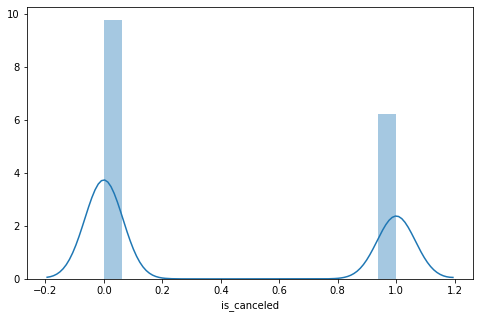

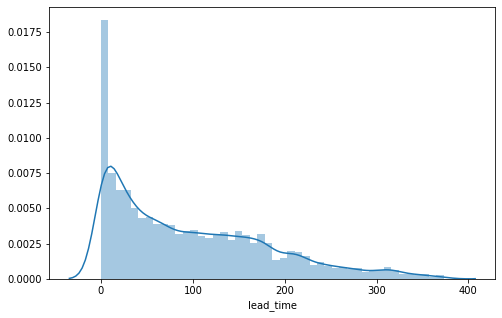

/opt/conda/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/conda/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


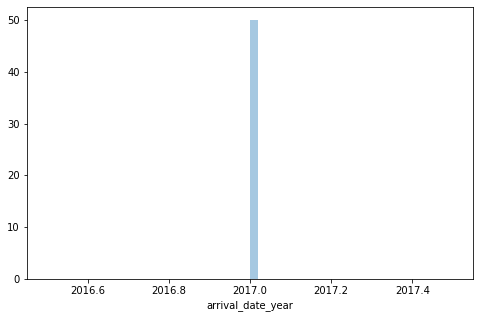

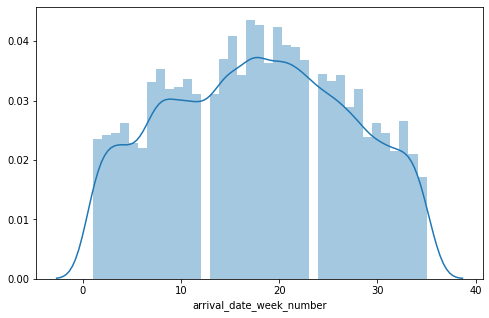

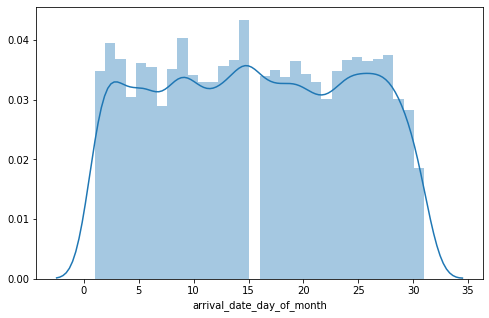

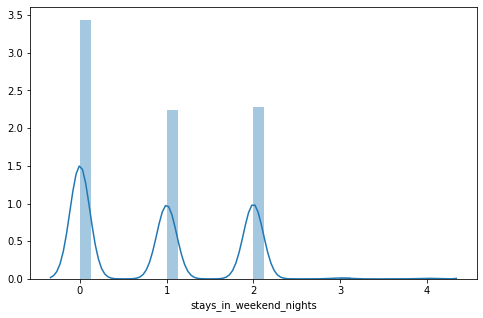

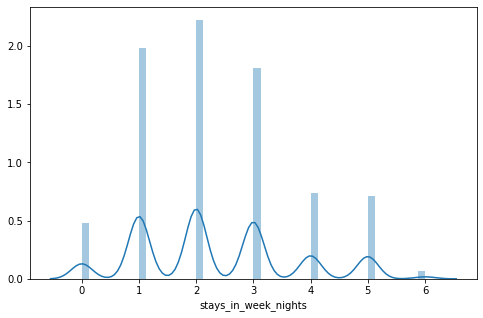

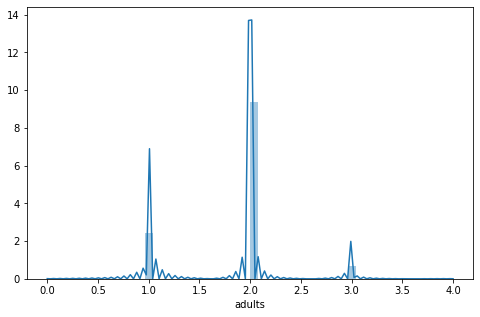

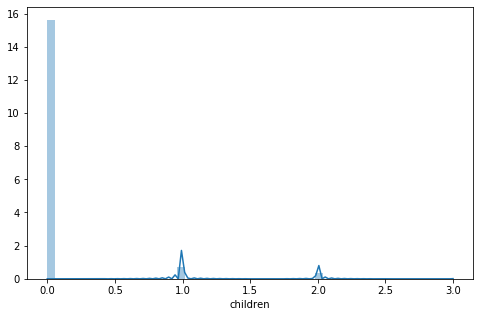

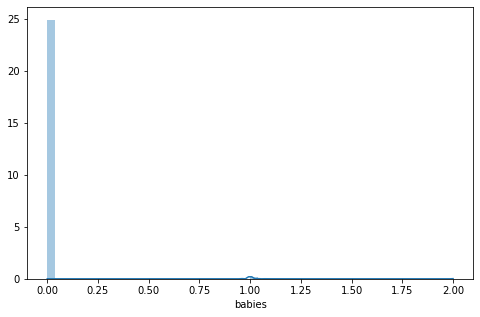

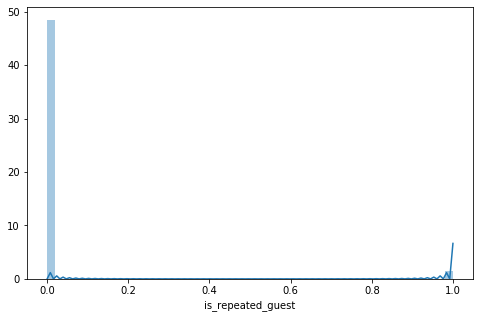

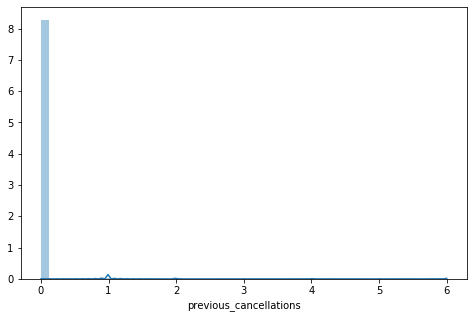

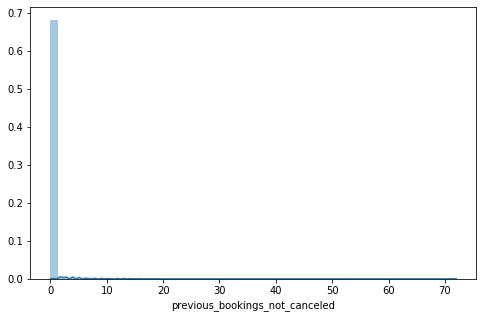

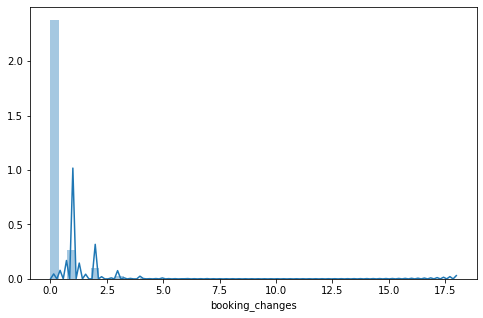

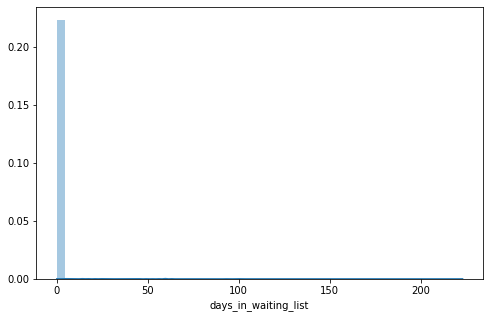

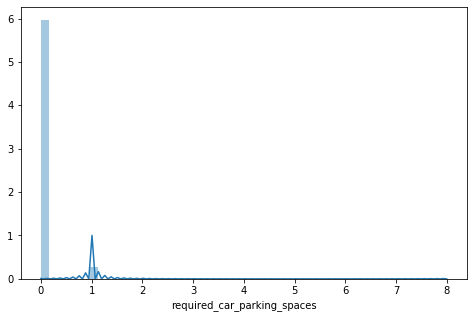

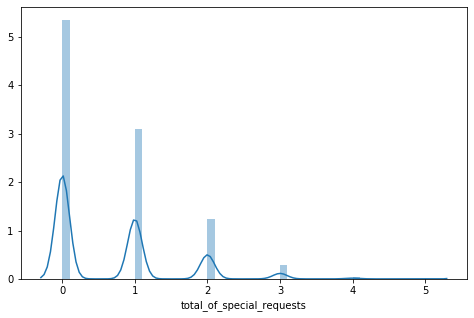

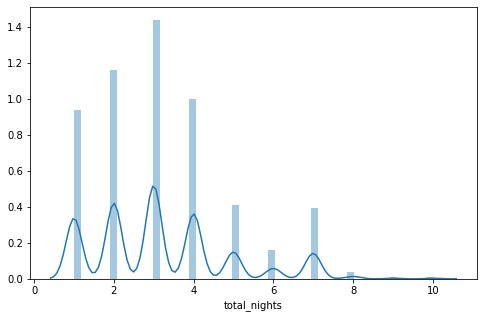

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

a = ['is_canceled',
'lead_time',
'arrival_date_year',
'arrival_date_week_number',
'arrival_date_day_of_month',
'stays_in_weekend_nights',
'stays_in_week_nights',
'adults',
'children',
'babies',
'is_repeated_guest',
'previous_cancellations',
'previous_bookings_not_canceled',
'booking_changes',
'days_in_waiting_list',
'required_car_parking_spaces',
'total_of_special_requests',
'total_nights']
for aa in a:
    plt.figure(figsize=(8,5))
    ax = sns.distplot(df_test[aa])
    plt.show()

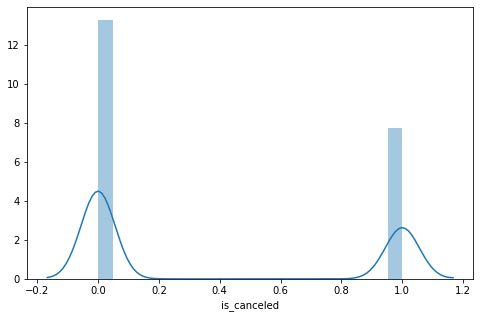

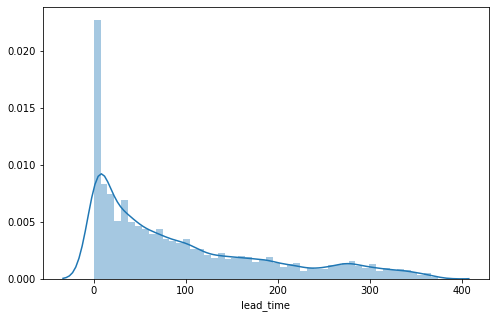

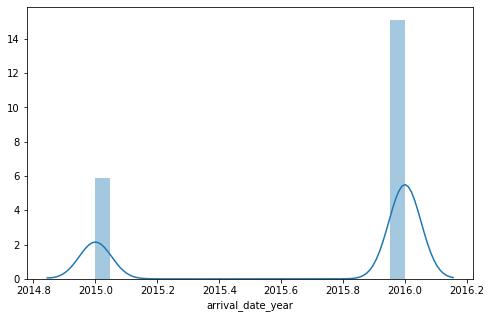

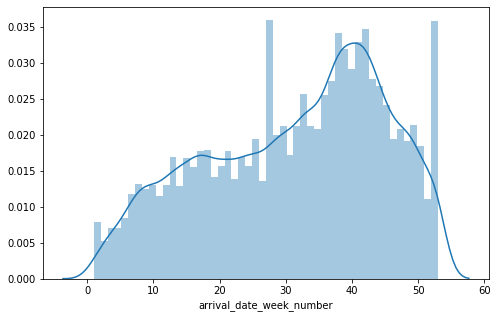

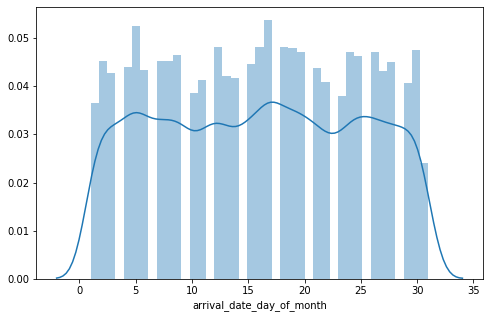

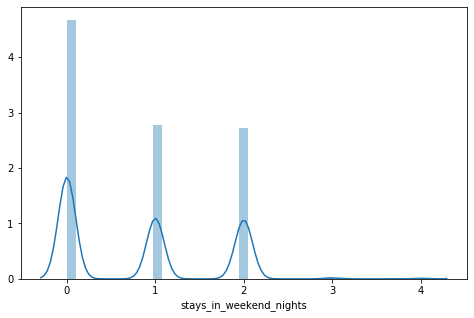

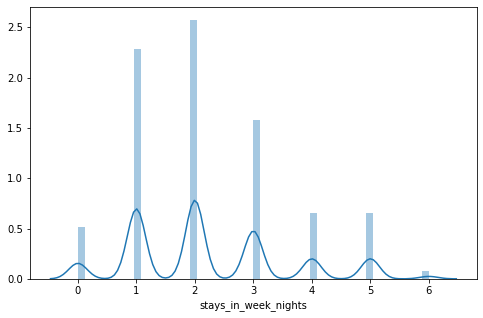

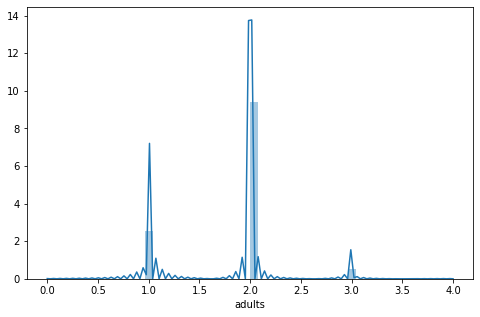

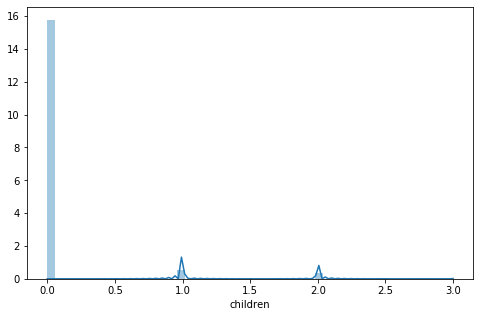

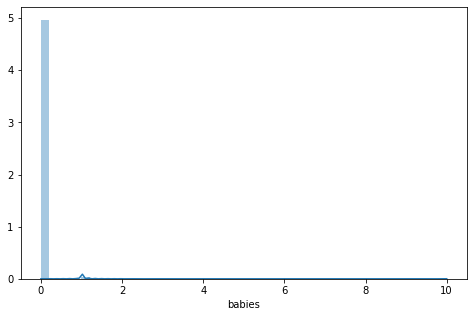

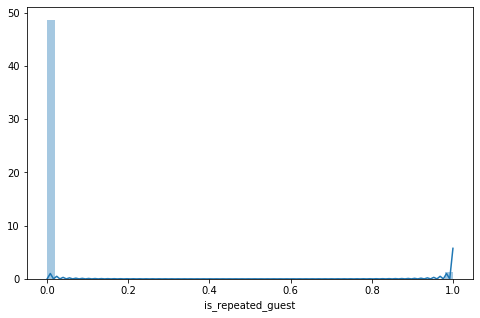

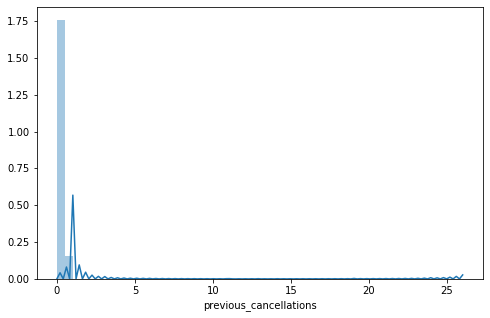

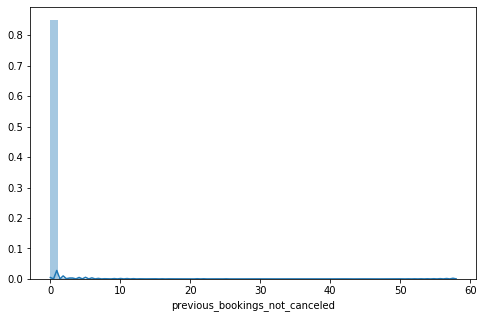

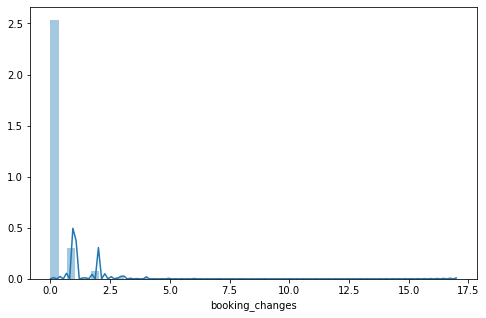

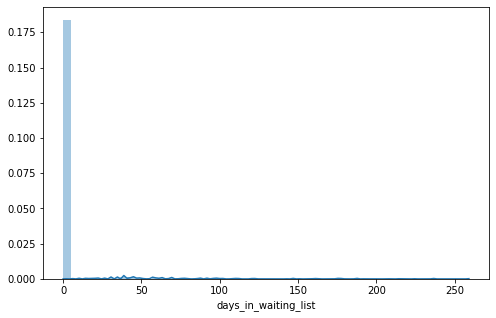

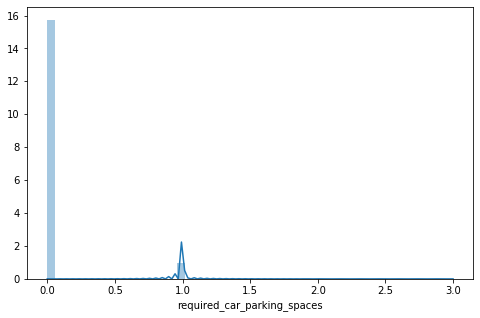

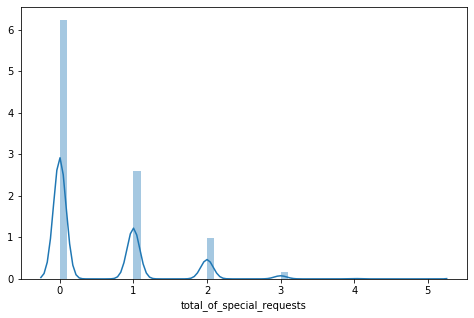

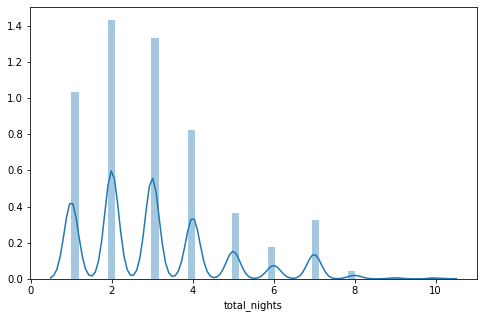

In [13]:
for aa in a:
    plt.figure(figsize=(8,5))
    ax = sns.distplot(df_train[aa])
    plt.show()

__ВЫВОД: Данные подготовлены к дальнейшей работе, а целевой признак практически одинаково распределен в тестовом и тренировочном датасете.__ Можно сказать что выбросов нет данные нормальные

In [14]:
### код ревьюера
# df_train['previous_bookings_not_canceled'].value_counts().sort_index()

### Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

__Сформулируем требование к нашей ML модели.__  
Задача предсказать максимальное количесво людей котрые откажутся и взять с них 80% стоимости номера за одни сутки.   
Эта сумма за год, должна превыщать 400 000₽ потраченных на разработку модели.  
В качестве целевого признака будем использовать: `is_canceled` — отмена заказа.  
В качесве признаков предполагаю использовать:  
* `babies` — количество младенцев;
* `booking_changes` — количество изменений параметров заказа;
* `children` — количество детей от 3 до 14 лет;
* `customer_type` — тип заказчика;
* `days_in_waiting_list` — сколько дней заказ ожидал подтверждения;
* `previous_bookings_not_canceled` — количество подтверждённых заказов у клиента;
* `previous_cancellations` – количество отменённых заказов у клиента;
* `reserved_room_type` — тип забронированной комнаты;
* `lead_time` — количество дней между датой бронирования и датой прибытия;
* `is_repeated_guest` — признак того, что гость бронирует номер второй раз;
Добавим их в отдельный список.  
И получим __дамми признаки__ для следующих столбцов:
`customer_type`, `reserved_room_type`

In [15]:
features2 = ['adults',
             'arrival_date_month',
             'arrival_date_week_number',
             'arrival_date_day_of_month',
             'babies',
             'booking_changes',
             'children',
             'country',
             'customer_type',
             'days_in_waiting_list',
             'distribution_channel',
             'is_repeated_guest',
             'lead_time',
             'meal',
             'previous_bookings_not_canceled',
             'previous_cancellations',
             'required_car_parking_spaces',
             'reserved_room_type',
             'stays_in_weekend_nights',
             'stays_in_week_nights',
             'total_nights',
             'total_of_special_requests']

In [16]:
target = ['is_canceled']
features = ['previous_bookings_not_canceled',
            'previous_cancellations',
            'reserved_room_type',
            'lead_time',
            'is_repeated_guest',
            'babies',
            'booking_changes',
            'children',
            'customer_type',
            'days_in_waiting_list']

In [17]:
# Посмотрим накорреляцию вообще всех цифровых параметров
corr = pd.DataFrame(df_train.corr()['is_canceled'])
# Сохраним цифровые столбцы в отдельный список.
digital_column = list(corr.index)
# посмотрим на все значения корреляции относительно столбца is_canceled — отмена заказа
corr[(corr['is_canceled'] > 0.2) | (corr['is_canceled'] < -0.2)]

,is_canceled
id,-0.241910
is_canceled,1.000000
lead_time,0.328142
total_of_special_requests,-0.257061


Что-то так себе картина да еще и `id` c `is_canceled` сюда попали. Сохраним в отдельный список все столбцы кроме `id` и `is_canceled`.

In [18]:
features_for_model = list(set(corr[(corr['is_canceled'] > 0.2) | (corr['is_canceled'] < -0.2)].index) - set(['id', 'is_canceled']))

Посомтрим, что осталось из не исследованных столбцов

In [19]:
features2 = list(set(features2) - set(digital_column))
for f in features2:
    print(f)
    print(pd.DataFrame(df_train.groupby([f])['is_canceled'].value_counts()))
    print(pd.DataFrame(df_train.groupby([f])['is_canceled'].value_counts(normalize=True)))
    print('\n\n')

country
                     is_canceled
country is_canceled             
ABW     0                      1
AGO     0                     85
        1                     55
ALB     0                      6
        1                      1
...                          ...
VNM     1                      2
ZAF     0                     21
        1                     15
ZMB     1                      1
ZWE     0                      1

[252 rows x 1 columns]
                     is_canceled
country is_canceled             
ABW     0               1.000000
AGO     0               0.607143
        1               0.392857
ALB     0               0.857143
        1               0.142857
...                          ...
VNM     1               0.400000
ZAF     0               0.583333
        1               0.416667
ZMB     1               1.000000
ZWE     0               1.000000

[252 rows x 1 columns]



customer_type
                             is_canceled
customer_type   is_canceled 

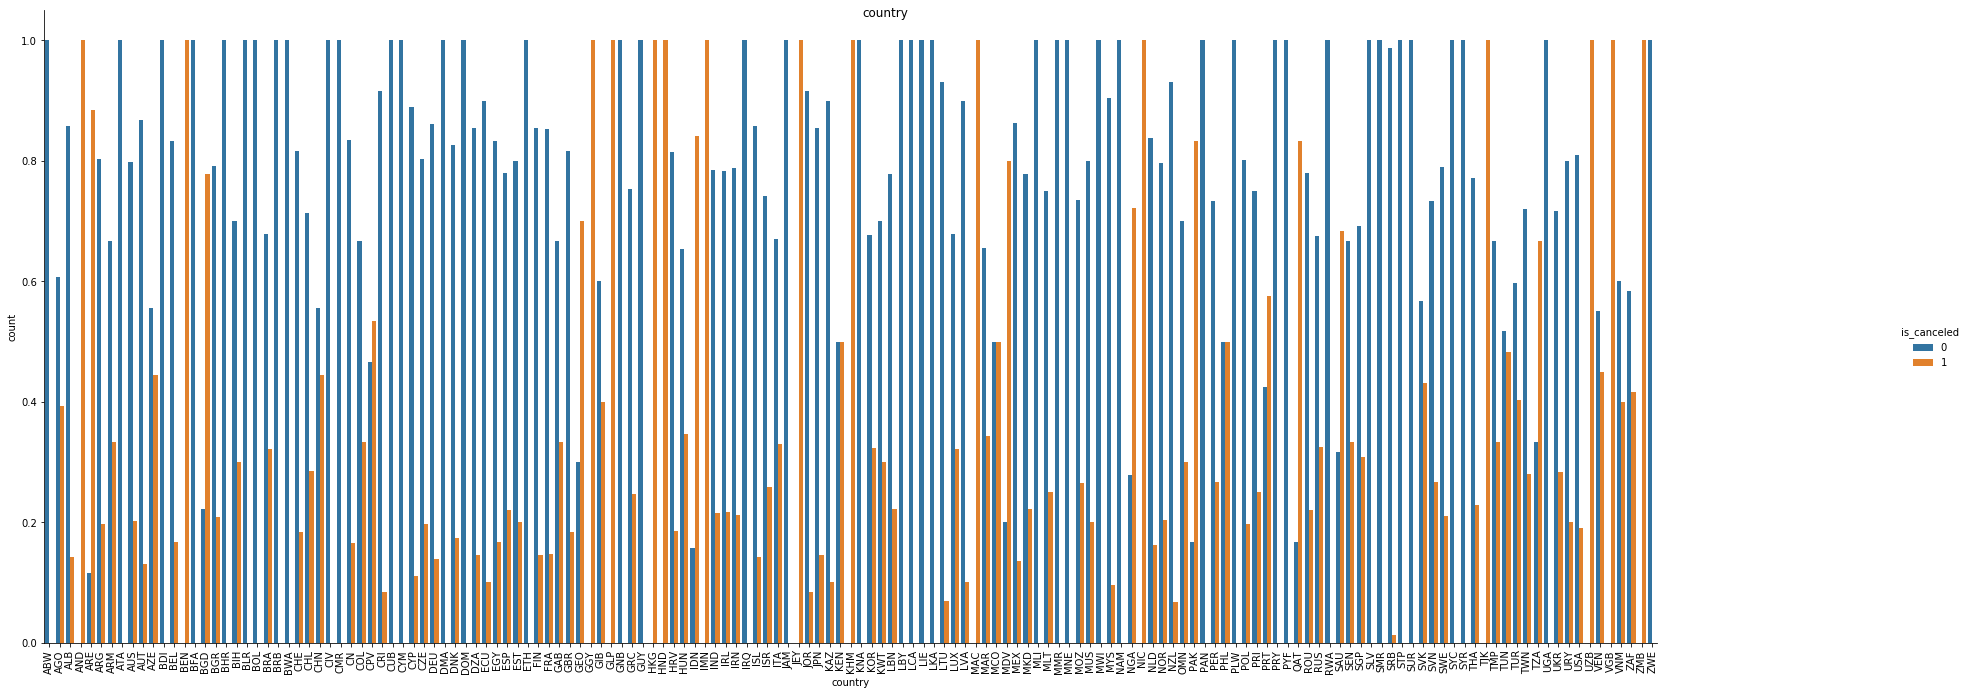

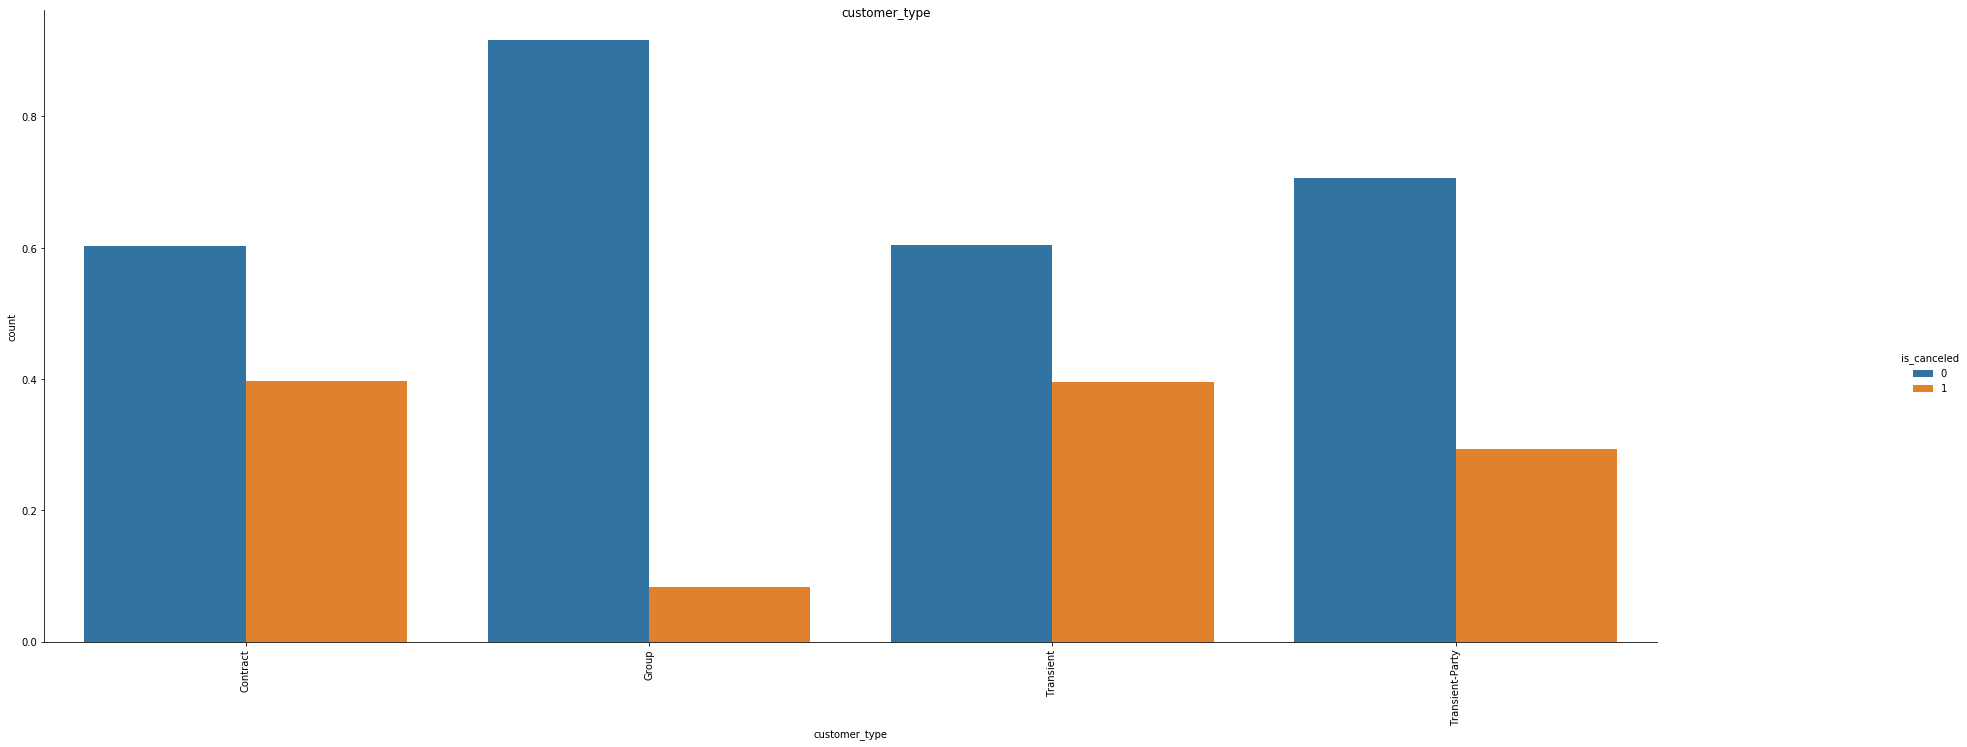

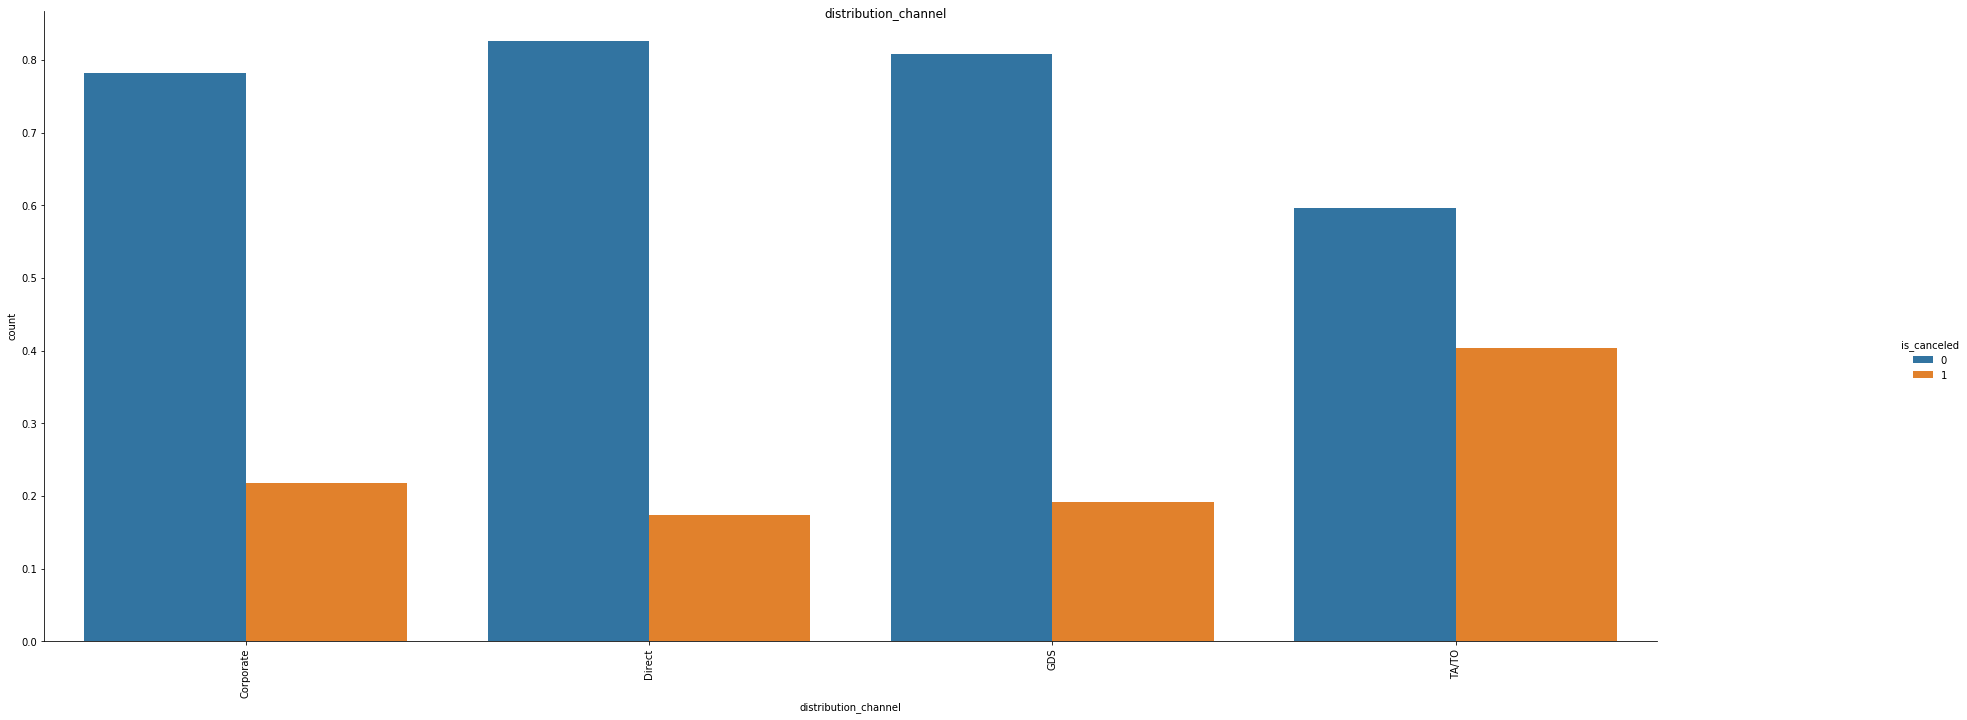

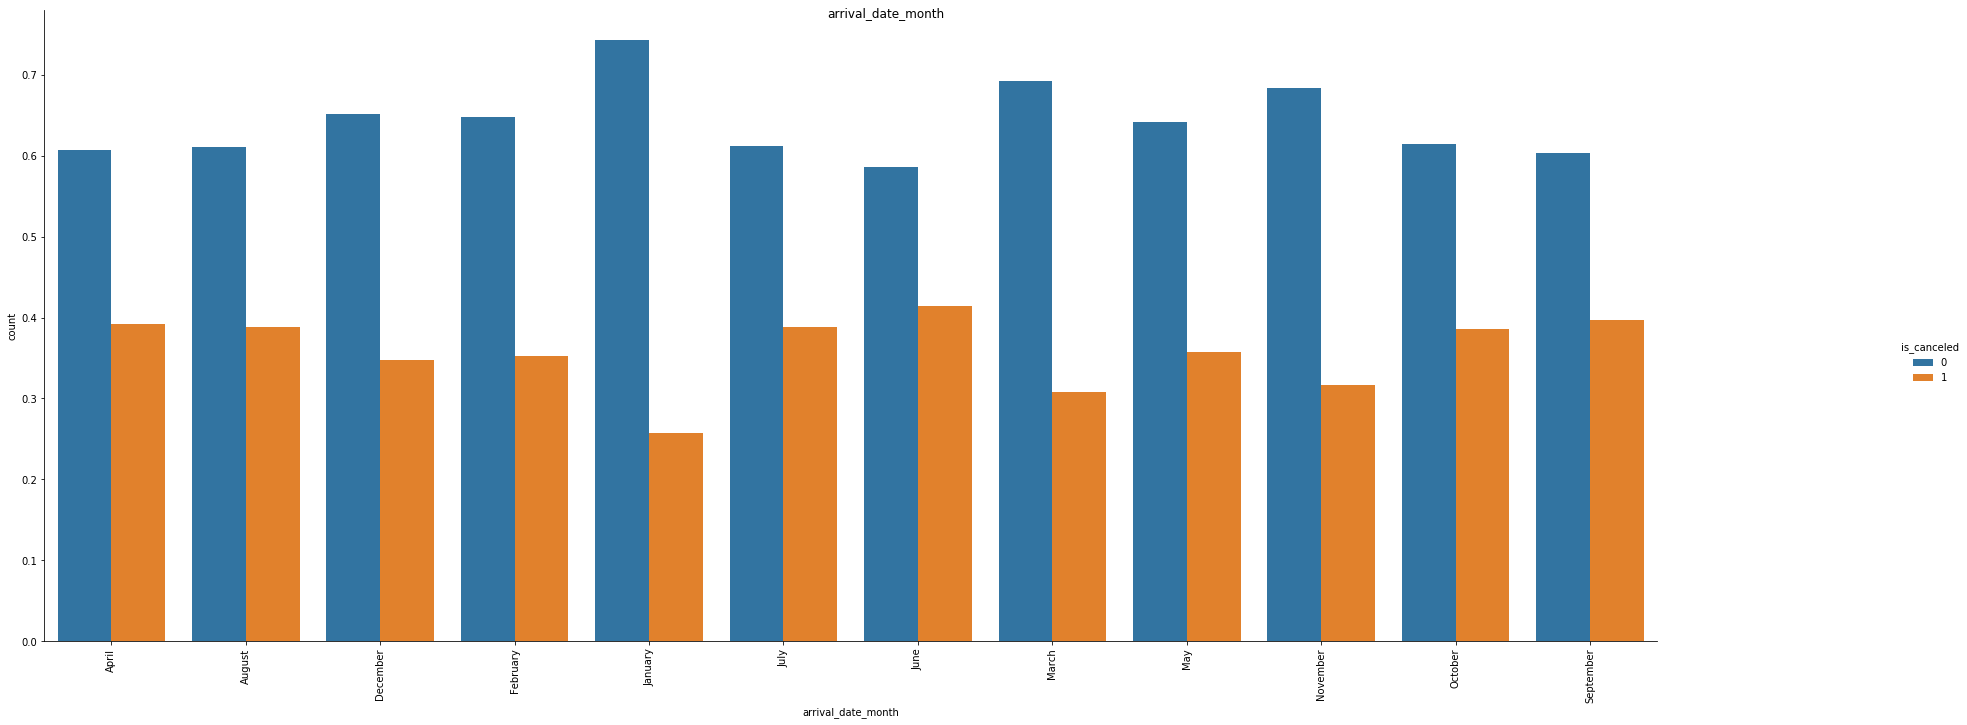

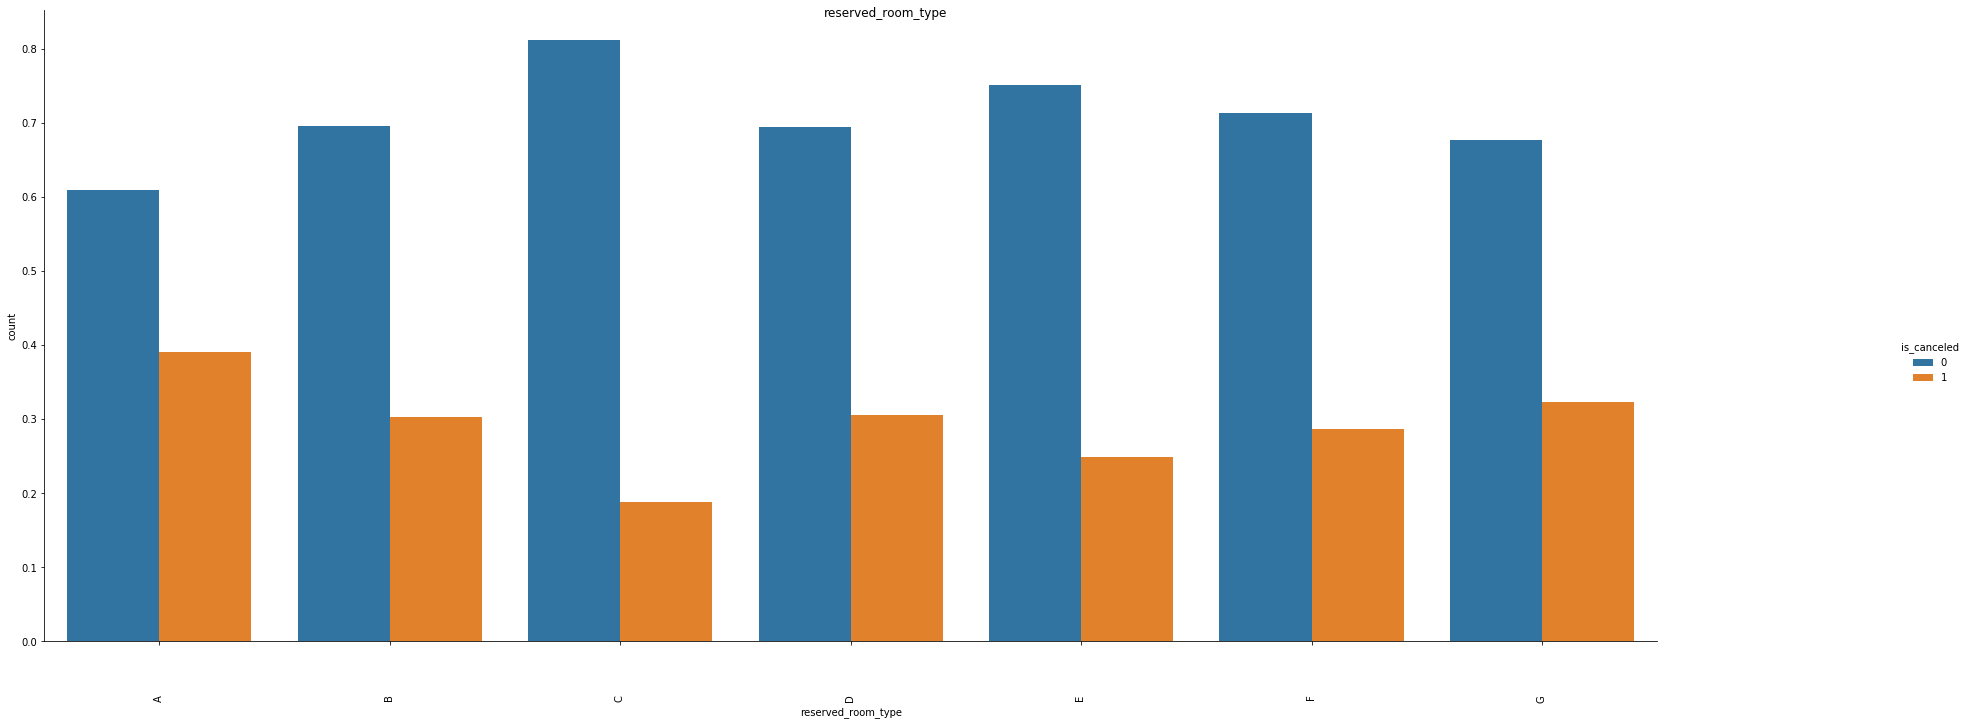

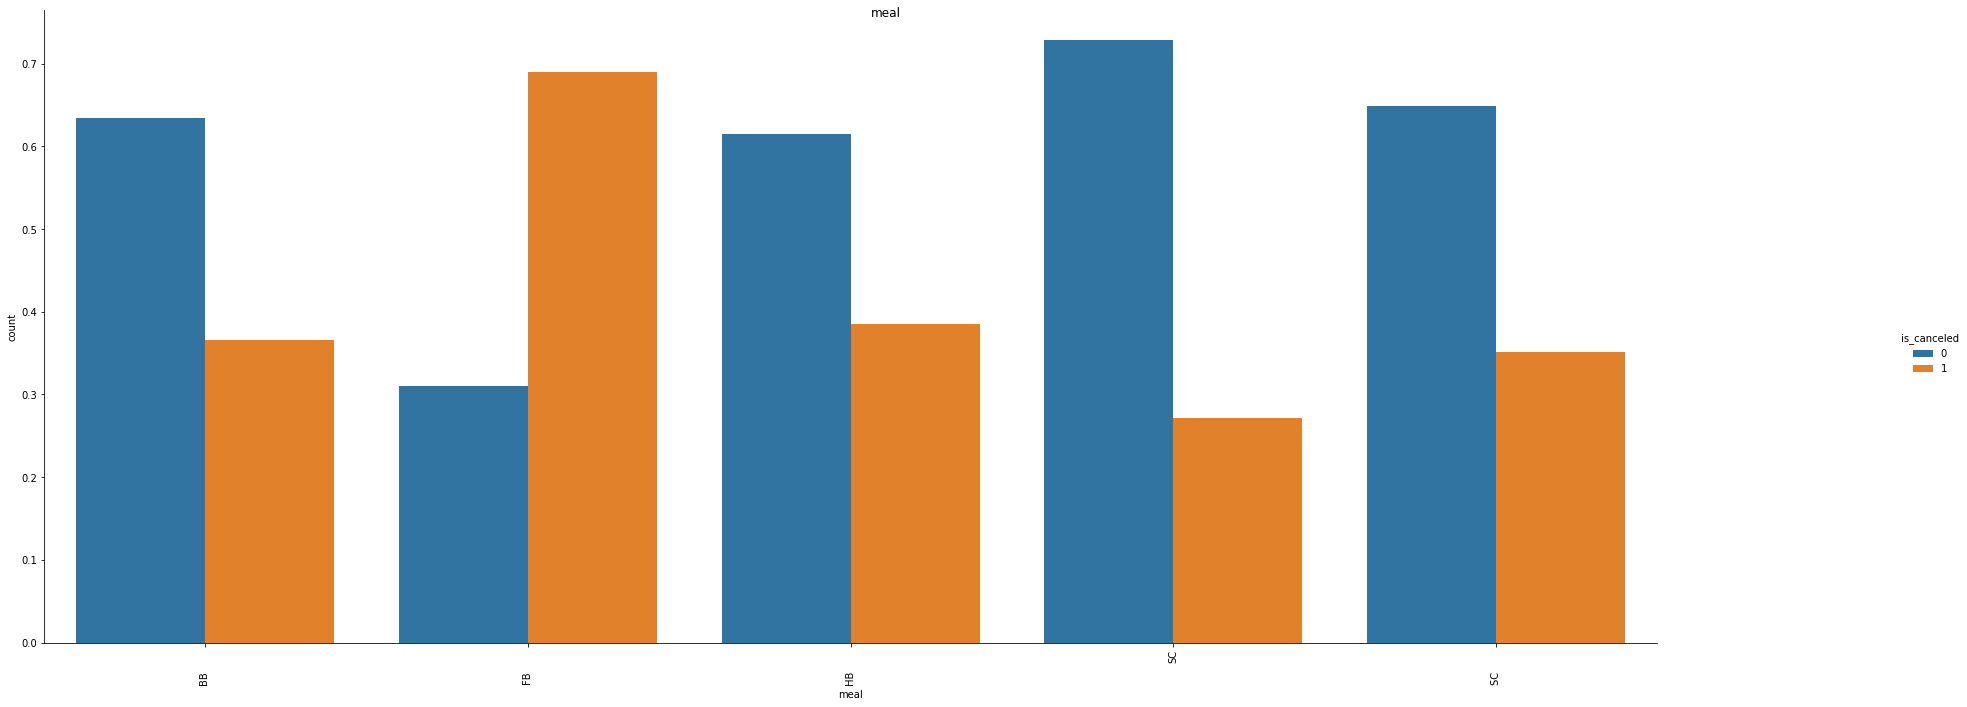

In [20]:
for f in features2:
    g = sns.catplot(data=df_train.groupby([f])['is_canceled'].value_counts(normalize=True).reset_index(name = 'count'), kind='bar', x=f, y='count', hue='is_canceled',  height=6)
    g.fig.set_figheight (10)
    g.fig.set_figwidth (30)
    g.fig.suptitle(f)
    plt.xticks(rotation=90)

Чёт яснее не стало. Посомтрим только на процент нулей в наборах

In [21]:
t = df_train.groupby(features2[0])['is_canceled'].value_counts(normalize=True).reset_index(name = 'count')
t = t.where(t.is_canceled == 0).dropna()
print(f'Максимум {t["count"].max()}, Минимум {t["count"].min()}, Среднее {t["count"].mean()}')
t

Максимум 1.0, Минимум 0.11538461538461539, Среднее 0.7863832476529087


,country,is_canceled,count
0,ABW,0.0,1.000000
1,AGO,0.0,0.607143
3,ALB,0.0,0.857143
7,ARE,0.0,0.115385
8,ARG,0.0,0.803738
...,...,...,...
240,USA,0.0,0.809524
243,VEN,0.0,0.550000
246,VNM,0.0,0.600000
248,ZAF,0.0,0.583333


In [22]:
pd.options.display.max_rows=1000
t = df_train.groupby(features2[1])['is_canceled'].value_counts(normalize=True).reset_index(name = 'count')
t = t.where(t.is_canceled == 0).dropna()
print(f'Максимум {t["count"].max()}, Минимум {t["count"].min()}, Среднее {t["count"].mean()}')
t

Максимум 0.9163763066202091, Минимум 0.6030589949016751, Среднее 0.707314393252336


,customer_type,is_canceled,count
0,Contract,0.0,0.603059
2,Group,0.0,0.916376
4,Transient,0.0,0.603961
6,Transient-Party,0.0,0.705861


In [23]:
t = df_train.groupby(features2[2])['is_canceled'].value_counts(normalize=True).reset_index(name = 'count')
t = t.where(t.is_canceled == 0).dropna()
print(f'Максимум {t["count"].max()}, Минимум {t["count"].min()}, Среднее {t["count"].mean()}')
t

Максимум 0.826645264847512, Минимум 0.595879090608587, Среднее 0.7533091512033478


,distribution_channel,is_canceled,count
0,Corporate,0.0,0.782631
2,Direct,0.0,0.826645
4,GDS,0.0,0.808081
6,TA/TO,0.0,0.595879


In [24]:
t = df_train.groupby(features2[3])['is_canceled'].value_counts(normalize=True).reset_index(name = 'count')
t = t.where(t.is_canceled == 0).dropna()
print(f'Максимум {t["count"].max()}, Минимум {t["count"].min()}, Среднее {t["count"].mean()}')
t

Максимум 0.742600422832981, Минимум 0.5855333762610002, Среднее 0.6411402818659834


,arrival_date_month,is_canceled,count
0,April,0.0,0.607410
2,August,0.0,0.611111
4,December,0.0,0.651992
6,February,0.0,0.648005
8,January,0.0,0.742600
10,July,0.0,0.611577
12,June,0.0,0.585533
14,March,0.0,0.692141
16,May,0.0,0.642292
18,November,0.0,0.683388


In [25]:
t = df_train.groupby(features2[4])['is_canceled'].value_counts(normalize=True).reset_index(name = 'count')
t = t.where(t.is_canceled == 0).dropna()
print(f'Максимум {t["count"].max()}, Минимум {t["count"].min()}, Среднее {t["count"].mean()}')
t

Максимум 0.8114035087719298, Минимум 0.6094730797409952, Среднее 0.7076637930018652


,reserved_room_type,is_canceled,count
0,A,0.0,0.609473
2,B,0.0,0.696512
4,C,0.0,0.811404
6,D,0.0,0.694151
8,E,0.0,0.751634
10,F,0.0,0.713108
12,G,0.0,0.677365


In [26]:
t = df_train.groupby(features2[5])['is_canceled'].value_counts(normalize=True).reset_index(name = 'count')
t = t.where(t.is_canceled == 0).dropna()
print(f'Максимум {t["count"].max()}, Минимум {t["count"].min()}, Среднее {t["count"].mean()}')
t

Максимум 0.7281553398058253, Минимум 0.31042128603104213, Среднее 0.5872901704682059


,meal,is_canceled,count
0,BB,0.0,0.633731
3,FB,0.0,0.310421
4,HB,0.0,0.614920
6,SC,0.0,0.728155
8,SC,0.0,0.649223


Добавим к `features_for_model` еще `country` и `meal` т.к. их разброс от среднего и макисмального и минимальног показался мне подозрительным.

In [27]:
features_for_model.extend(['country', 'meal'])
features_for_model

['lead_time', 'total_of_special_requests', 'country', 'meal']

In [28]:
df_train[features_for_model]

,lead_time,total_of_special_requests,country,meal
0,7.0,0,GBR,BB
1,14.0,1,GBR,BB
2,0.0,0,PRT,BB
3,9.0,1,PRT,FB
4,85.0,1,PRT,BB
...,...,...,...,...
65224,23.0,2,CHN,BB
65225,53.0,3,FRA,HB
65226,7.0,1,FRA,BB
65227,17.0,1,FRA,SC


Делаем дамми для логистической регрессии и прямое кодирование для дерева решений, и случайного леса

In [29]:
#Избавимся от пробелов в столбцах `meal` и `country`
df_train['meal'] = df_train['meal'].str.replace(' ','')
df_test['meal'] = df_test['meal'].str.replace(' ','')
df_train['country'] = df_train['country'].str.replace(' ','')
df_test['country'] = df_test['country'].str.replace(' ','')

In [30]:
print(sorted(df_train['meal'].unique()))
print(sorted(df_test['meal'].unique()))
# тут всё удачно можно делать дамми

print(len(df_train['country'].unique()))
print(len(df_test['country'].unique()))
# тут на прямую дамми не прокатит

['BB', 'FB', 'HB', 'SC']
['BB', 'FB', 'HB', 'SC']
155
143


In [31]:
df_train_logreg_f = df_train[features_for_model].copy()
df_test_logreg_f = df_test[features_for_model].copy()

df_train_tree_f = df_train[features_for_model].copy()
df_test_tree_f = df_test[features_for_model].copy()

df_train_t = df_train[target].copy()
df_test_t = df_test[target].copy()

In [32]:
# Данные для логистической регрессии
frames = [df_train_logreg_f, df_test_logreg_f]
mdf = pd.concat(frames, keys=['train', 'test'])
# Получим дамми признаки
mdf = pd.get_dummies(mdf, columns=['country', 'meal'], prefix=['country', 'meal'])

# стандартизируем
# V4 тут Изменения
# Отключу предупреждения о копировании
pd.options.mode.chained_assignment = None
scaler.fit(mdf.loc['train'][['total_of_special_requests']])

mdf.loc['train']['total_of_special_requests'] = scaler.transform(mdf.loc['train'][['total_of_special_requests']])
mdf.loc['test']['total_of_special_requests'] = scaler.transform(mdf.loc['test'][['total_of_special_requests']])

scaler.fit(mdf.loc['train'][['lead_time']])
mdf.loc['train']['lead_time'] = scaler.transform(mdf.loc['train'][['lead_time']])
mdf.loc['test']['lead_time'] = scaler.transform(mdf.loc['test'][['lead_time']])

# вернем обратно
df_train_logreg_f = mdf.loc['train'].copy()
df_test_logreg_f = mdf.loc['test'].copy()

In [33]:
# Данные для случайного дерева и леса решений
frames = [df_train_tree_f, df_test_tree_f]
mdf2 = pd.concat(frames, keys=['train', 'test'])
# Порядковое кодирование
encoder.fit(mdf2[['country']])
mdf2[['country']] = encoder.transform(mdf2[['country']])
encoder.fit(mdf2[['meal']])
mdf2[['meal']] = encoder.transform(mdf2[['meal']])
# вернем обратно
df_train_tree_f = mdf2.loc['train'].copy()
df_test_tree_f = mdf2.loc['test'].copy()

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера v5 ✔️</b> 

Да, так что можно в одну строчку :)
</div>

In [34]:
# Похоже на то, что в столбцах значения одинаковые можно применять дамми признаки
print(sorted(list(df_train['customer_type'].unique())))
print(sorted(list(df_test['customer_type'].unique())))
print(sorted(list(df_train['reserved_room_type'].unique())))
print(sorted(list(df_test['reserved_room_type'].unique())))

['Contract', 'Group', 'Transient', 'Transient-Party']
['Contract', 'Group', 'Transient', 'Transient-Party']
['A               ', 'B               ', 'C               ', 'D               ', 'E               ', 'F               ', 'G               ']
['A               ', 'B               ', 'C               ', 'D               ', 'E               ', 'F               ', 'G               ']


<div class="alert alert-block alert-info">
<b>Комментарий студента V1</b> 
Похоже значения в столбцах для дамми признаков одинаковые.
</div>

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера v2 ✔️</b> 
    
Да, одинаковые, но так будет далеко не всегда. Вполне могло оказаться, что в тестовой выборке не встречаются какие-нибудь из категорий. Тогда код пришлось бы переписывать.
</div>


In [35]:
# Буду использовать для подсчёта прибыли.
# Создадим копию данных для обучения моделей.
df_train_target = df_train[target].copy()
df_train_features = df_train[features].copy()

df_test_target = df_test[target].copy()
df_test_features = df_test[features].copy()

# Получим дамми признаки
df_train_features = pd.get_dummies(df_train_features, 
                                   columns=['customer_type', 'reserved_room_type'], 
                                   prefix=['customer','room'])
df_test_features = pd.get_dummies(df_test_features, 
                                  columns=['customer_type', 'reserved_room_type'], 
                                  prefix=['customer','room'])

Посмотрим, что получилось

На основе данных предоставленных в описании проекта составим словарь `room_type_dict` с ценами за ночь в номере `night_price`, стоимостью обслуживания `service` и словарь с сезонным коэффициентом `season_ratio_dict` где весна `spring`, лето `summer`, осень `autumn`.

In [40]:
season_ratio_dict = {'spring':1.20,'summer':1.40,'autumn':1.20,'winter':1}
seasons_dict = {
             1: 'winter',
             2: 'spring',
             3: 'summer',
             4: 'autumn'
}
room_type_dict = {'A':{'night_price':1000,'service':400},
                  'B':{'night_price':800,'service':350},
                  'C':{'night_price':600,'service':350},
                  'D':{'night_price':550,'service':150},
                  'E':{'night_price':500,'service':150},
                  'F':{'night_price':450,'service':150},
                  'G':{'night_price':350,'service':150},
                  'H':{'night_price':300,'service':100},
                 }

Посчитаем прибыль отеля.  
Буду учитывать сезонность дней если человек прожил 2 ночи весной то цена ночи +0.2 и 2 ночи летом то цена ночи +0.4

In [41]:
# Подсчёт дохода с клиента и расходов на обслуживание номера + прибыли
def total_sum(data):
    # Дата въезда
    start_date = pd.to_datetime(str(data['arrival_date_year']) + 
                                data['arrival_date_month'] + 
                                str(data['arrival_date_day_of_month']), format='%Y%B%d')
    # Дата отъезда
    end_date = start_date + pd.to_timedelta(data['total_nights']-1, unit='D')
    # Тип комнаты
    room_type = data['reserved_room_type'].replace(' ','')
    # Базовая цена ночи
    night_price = room_type_dict[room_type]['night_price']
    # Итоговая стоимость
    total_price = 0
    
    # Проверка в одном сезоне въехал человек
    if seasons_dict[(start_date.month % 12 + 3)// 3] == seasons_dict[(end_date.month % 12 + 3)// 3]:
        season = seasons_dict[(start_date.month % 12 + 3)// 3]
        total_price = data['total_nights'] * night_price * season_ratio_dict[season]
    else:
        for i in pd.date_range(start_date,end_date):
            season = seasons_dict[(i.month % 12 + 3)// 3]
            price =  night_price * season_ratio_dict[season]
            total_price += price
    return total_price

# Уборку считал так 1 при въезде гостя + 1 при выезде + каждые 2 дня проживания
# Если человек живет 6 дней то 2 уборки приехал и уехал + 2 каждые 2 дня итого 4
def serv_sum(data):
    room_type = data['reserved_room_type'].replace(' ','')
    service_price = room_type_dict[room_type]['service']
    if data['total_nights']%2 == 0:
        return ((data['total_nights'] / 2) + 1) * service_price
    else:
        return (int(data['total_nights'] / 2) + 2) * service_price

In [42]:
df_train['total_price'] = 0
df_test['total_price'] = 0

df_train['serv_price'] = 0
df_test['serv_price'] = 0

df_train['total_price'] = df_train.apply(total_sum, axis = 1)
df_test['total_price'] = df_test.apply(total_sum, axis = 1)

df_train['serv_price'] = df_train.apply(serv_sum, axis = 1)
df_test['serv_price'] = df_test.apply(serv_sum, axis = 1)

df_train['profit'] = df_train['total_price'] - df_train['serv_price']
df_test['profit'] = df_test['total_price'] - df_test['serv_price']

In [43]:
# вот так делать нельзя это не читабельно совсем. Это ошибка, но исправлять я её не стану.
def aaaa(aaaaa):
    aaaaaaa = aaaaa['reserved_room_type'].replace(' ','')
    aaaaaa = room_type_dict[aaaaaaa]['service']
    return aaaaaa

In [44]:
df_train['loss'] = 0
df_test['loss'] = 0

df_train['loss'] = df_train.apply(aaaa, axis = 1)
df_test['loss'] = df_test.apply(aaaa, axis = 1)

In [45]:

profit_train = df_train[df_train['is_canceled'] == 0]['profit'].sum()
profit_test = df_test[df_test['is_canceled'] == 0]['profit'].sum()

loss_train = df_train[df_train['is_canceled'] == 1]['loss'].sum()
loss_test = df_test[df_test['is_canceled'] == 1]['loss'].sum()

print(f'Прибыль фактическая на тренировочном датасете: {profit_train - loss_train:,.2f}')
print(f'Прибыль фактическая на тестовом датасете: {profit_test - loss_test:,.2f}')

Прибыль фактическая на тренировочном датасете: 85,020,880.00
Прибыль фактическая на тестовом датасете: 42,580,350.00


__Дерево решений__

In [46]:
criterions = ('gini', 'entropy')
max_featuress = ('auto', 'sqrt', 'log2', None)
best_result = 0
for crit in criterions:
    for max_f in max_featuress:
        for dept in range(1,21):
            model = DecisionTreeClassifier(random_state=12345, max_depth=dept, criterion=crit, max_features=max_f)
            scores = cross_val_score(model, df_train_tree_f, df_train_t , cv=5, scoring='f1')
            result = sum(scores) / len(scores)
            if result > best_result:
                best_result = result
                best_crit = crit
                best_max_f = max_f
                best_dept = dept
                best_accuracy = result
                best_modelDC = model
print(f'cross_val_score: {best_result}, max_depth: {best_dept}, criterion: {best_crit}, max_features: {best_max_f}')

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-sco

cross_val_score: 0.6539291449762048, max_depth: 4, criterion: gini, max_features: None


__Случайный лес__

In [47]:
best_result = 0
for est in range(1, 5, 1):
    print(est)
    for dept in range(1,16):
        model = RandomForestClassifier(random_state=12345, n_estimators = est, max_depth=dept)
        scores = cross_val_score(model, df_train_tree_f, df_train_t.values.ravel(), cv=5, scoring='f1')
        result = sum(scores) / len(scores)
        if result > best_result:
            best_result = result
            best_est = est
            best_dept = dept
            best_accuracy = result
            best_modelR = model
            
print(f'cross_val_score: {best_accuracy}, max_depth: {best_dept}, n_estimators: {best_est}')

1


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


2


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


3


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


4


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


cross_val_score: 0.6451792374264971, max_depth: 4, n_estimators: 3


__Логистическая регрессия__

In [48]:
best_result = 0
solvers = ('lbfgs', 'liblinear')
for solver in solvers:
    model = LogisticRegression(random_state=12345, solver=solver, max_iter=10000)
    scores = cross_val_score(model, df_train_logreg_f, df_train_t.values.ravel(), cv=5, scoring='f1')
    result = sum(scores) / len(scores)
    if result > best_result:
        best_result = result
        best_solv = solver
        best_modelL = model
        best_accuracy = result
        
print(f'cross_val_score: {best_accuracy}, best_solv: {best_solv}')

cross_val_score: 0.6172473883037906, best_solv: lbfgs


__ВЫВОД: Наилучший результат показал "дерево решений" с результатом cross_val_score: 0.65.__

Попробуем проверить на тестовой выборке

In [49]:
# max_depth: 4, criterion: gini, max_features: None
dept=4
crit='gini'
max_f = None
model = DecisionTreeClassifier(random_state=12345, max_depth=dept, criterion=crit, max_features=max_f)
model.fit(df_train_tree_f, df_train_t)
predictions = model.predict(df_test_tree_f)

In [50]:
# Качесво модели на тестовой выборке
from sklearn.metrics import f1_score

dept=4
crit='gini'
max_f = None
model = DecisionTreeClassifier(random_state=12345, max_depth=dept, criterion=crit, max_features=max_f)
model.fit(df_train_tree_f, df_train_t)
predictions = model.predict(df_test_tree_f)

f1_score_test = f1_score(df_test_t, predictions) 
f1_score_test

0.571903490656324

In [51]:
def total_sum_canceled(data):
    # Дата въезда
    start_date = pd.to_datetime(str(data['arrival_date_year']) + 
                                data['arrival_date_month'] + 
                                str(data['arrival_date_day_of_month']), format='%Y%B%d')
    # Тип комнаты
    room_type = data['reserved_room_type'].replace(' ','')
    # Базовая цена ночи
    night_price = room_type_dict[room_type]['night_price']
    service_price = room_type_dict[room_type]['service']
    # Итоговая стоимость
    total_price = 0
    season = seasons_dict[(start_date.month % 12 + 3)// 3]
    # Вычитал вот в этой строке
    total_price = (((night_price * season_ratio_dict[season]) + service_price) * 0.8) - (service_price)
    return total_price

In [52]:
df_test['predict'] = predictions
df_result = df_test[(df_test['is_canceled'] == df_test['predict']) & (df_test['is_canceled'] == 1)].copy()
df_result['sum_canceled'] = 0
df_result['sum_canceled'] = df_result.apply(total_sum_canceled, axis = 1)

In [53]:
itog_profit = df_result['sum_canceled'].sum()
print(f'Прибыль от отменнённых номеров при условии, что пользователь оставит депозит: {itog_profit:,.2f}₽')

Прибыль от отменнённых номеров при условии, что пользователь оставит депозит: 4,936,050.00₽


### Шаг 5. Опишите портрет «ненадёжного» клиента

Сначала посотмрим на ранее определенны признаки

In [54]:
#Создадим столбец с объединением наших признаков в один
df_test['person'] = df_test[features_for_model].apply(
    lambda x: ','.join(x.astype(str)),axis=1)

В качестве отмены подразумеваю, что `is_canceled = 1` 

In [55]:
# Посчитаем количесво нулевых и не нулевых значений по новому признаку также посчитаем процент нулевых значений
result = pd.concat([pd.DataFrame(df_test[df_test['is_canceled'] == 0]['person'].value_counts()), 
           pd.DataFrame(df_test[df_test['is_canceled'] == 1]['person'].value_counts())], axis=1,sort=True)
result.columns = ['null', 'one']
result['proc'] = result['one'] / (result['null'] + result['one'])

# Выведем признаки с самым большим процентом и количесвом отмен
result[(result['one'] > 50) & (result['proc'] > 0.8)].sort_values('null', ascending=False).head(50)

,null,one,proc
"175.0,0,PRT,BB",19.0,81.0,0.810000
"28.0,0,PRT,BB",6.0,108.0,0.947368
"135.0,0,PRT,BB",4.0,57.0,0.934426
"104.0,0,PRT,BB",2.0,80.0,0.975610
"150.0,0,PRT,BB",2.0,70.0,0.972222
"156.0,0,PRT,BB",2.0,99.0,0.980198
"52.0,0,PRT,BB",2.0,56.0,0.965517
"54.0,0,PRT,BB",2.0,58.0,0.966667
"59.0,0,PRT,BB",2.0,84.0,0.976744
"87.0,0,PRT,BB",2.0,52.0,0.962963


In [56]:
result.reset_index(inplace=True)
result = result.join(result['index'].str.split(',', expand=True))
result.columns=['index','null','one','proc'] + features_for_model
result[(result['one'] > 70) & (result['proc'] > 0.8)].sort_values('null', ascending=False).head(50)

,index,null,one,proc,lead_time,total_of_special_requests,country,meal
4172,"175.0,0,PRT,BB",19.0,81.0,0.810000,175.0,0,PRT,BB
7462,"28.0,0,PRT,BB",6.0,108.0,0.947368,28.0,0,PRT,BB
578,"104.0,0,PRT,BB",2.0,80.0,0.975610,104.0,0,PRT,BB
3263,"156.0,0,PRT,BB",2.0,99.0,0.980198,156.0,0,PRT,BB
10488,"59.0,0,PRT,BB",2.0,84.0,0.976744,59.0,0,PRT,BB
1913,"129.0,0,PRT,BB",1.0,84.0,0.988235,129.0,0,PRT,BB
4653,"186.0,0,PRT,BB",1.0,84.0,0.988235,186.0,0,PRT,BB
9037,"38.0,0,PRT,BB",1.0,106.0,0.990654,38.0,0,PRT,BB
10685,"61.0,0,PRT,BB",1.0,81.0,0.987805,61.0,0,PRT,BB


In [57]:
#Расшифруем признак:  
#Выходит, что часто ненадёжные клиенты это люди котрые делают
#    первый заказ, без отмененных заказов, бронирующие комнаты класса А, индивидуально въезжающие в отель, бронирующие за долго до въезда в отель.

In [58]:
pd.DataFrame({'Признаки': list(df_train_tree_f.columns),
              'Веса': list(model.feature_importances_)}).sort_values(by='Веса', ascending=False)

,Признаки,Веса
2,country,0.413199
0,lead_time,0.405059
1,total_of_special_requests,0.150025
3,meal,0.031717


Модель считает, что основной признак для нас это:
* country - страна
* lead_time - количество дней между датой бронирования и датой прибытия;
* previous_cancellations - количество отменённых заказов у клиента;
* total_of_special_requests - количество специальных отметок

Есть страна в котрой люди чаще отменяют заказы чем в отсальных, а также если человек отменил раз отменит и второй раз. А вообще все равно, что думает модель кторая предсказывает меньше всех прибыли.

### Шаг 6. Напишите общий вывод

Можно сказать, что самая первая модель предсказывала 7 000 000 прибыли, но сделанная по правилам предсказывает 4,936,050.00 что судя по всему нам болжно нравится больше.

а самой лучшей моделью среди этих моделий оказалась дерево решений которая чуть умнее дерева с результатом cross_val_score: 0.6539291449762048.

В заключении можно сказать, сколько дереву букварь не давай оно всёравно все деньги просадит.